In [1]:
import pandas as pd
import numpy as np
import pandas_profiling as pp
import fbprophet
from fbprophet.plot import plot_plotly, plot_components_plotly

In [2]:
# load the zipcodes we are focusing on. It is formatted with column names as [zipcode, city, rank]
zipcodes = pd.read_csv('./zipcodes.csv')
# My dataset strips the leading 0 from zipcodes, which happens to be what the other dataset came as too. Since they both do this, the sets can still be compared without additional work (unlike R)
zipcodes['zipcode'] = zipcodes['zipcode'].astype(str)

#load the listing data
data = pd.read_csv('./downloads/RDC_Inventory_Core_Metrics_Zip_History.csv', header=0, parse_dates=True, low_memory=False)[:-2] # remove last two rows, which have shown themselvse as weird
data['year-month'] = pd.to_datetime(data['month_date_yyyymm'], format='%Y%m')

In [3]:
local_data = data[data['postal_code'].isin(zipcodes['zipcode'])]
local_listing_sum = local_data[['year-month', 'active_listing_count']].groupby(['year-month']).sum().reset_index().rename(columns = {'year-month': 'ds', 'active_listing_count': 'y'})

In [4]:
print(local_data)

       month_date_yyyymm postal_code           zip_name flag  \
3768              202103       94102  san francisco, ca  NaN   
6556              202103       94112  san francisco, ca  NaN   
10860             202102       94102  san francisco, ca    *   
12547             202102       94112  san francisco, ca  NaN   
26486             202101       94102  san francisco, ca    *   
...                  ...         ...                ...  ...   
829132            201609       94112  san francisco, ca  NaN   
839687            201608       94112  san francisco, ca  NaN   
846793            201608       94102  san francisco, ca  NaN   
857688            201607       94112  san francisco, ca  NaN   
869169            201607       94102  san francisco, ca  NaN   

        median_listing_price  median_listing_price_mm  \
3768                694495.0                  -0.0602   
6556               1225000.0                  -0.0176   
10860               739000.0                  -0.0134   
125

In [5]:
profile = pp.ProfileReport(local_data, 'mls profile report')

In [6]:
profile

Summarize dataset:   0%|          | 0/50 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
local_listing_sum.tail() # looks good

,ds,y
52,2020-11-01,100.0
53,2020-12-01,76.0
54,2021-01-01,57.0
55,2021-02-01,69.0
56,2021-03-01,73.0


In [8]:
m = fbprophet.Prophet()
# we have an inventory floor of 0, so let's establish that
local_listing_sum['floor'] = 0
m.fit(local_listing_sum)
# future does NOT predict, it simply makes timestamps into the future on a monthly frequency
future = m.make_future_dataframe(periods=12, freq = 'MS')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

,ds,yhat,yhat_lower,yhat_upper
54,2021-01-01,42.644584,22.638796,61.863778
55,2021-02-01,53.199437,32.152993,73.351983
56,2021-03-01,53.706501,32.248920,72.373227
57,2021-04-01,47.432053,27.296340,66.634644
58,2021-05-01,63.547189,42.738587,84.074016
59,2021-06-01,64.596400,43.675705,85.593061
60,2021-07-01,79.132048,58.100612,99.445727
61,2021-08-01,80.646246,60.204672,101.844549
62,2021-09-01,86.609718,66.501516,106.663953
63,2021-10-01,90.862329,70.482385,111.112039


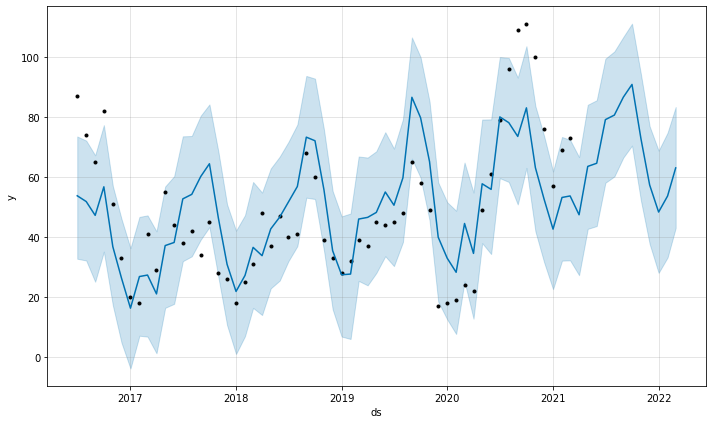

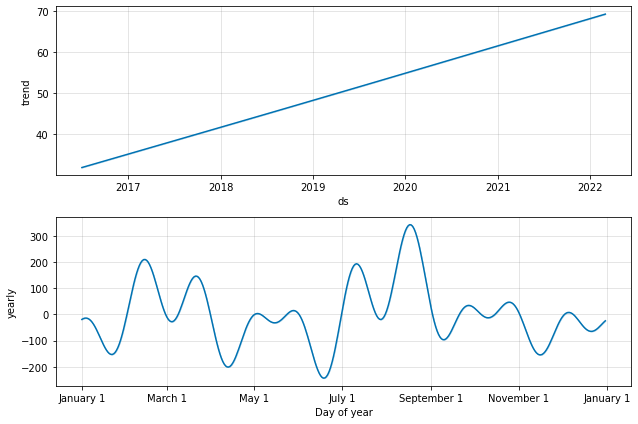

In [10]:
fig1 = m.plot(forecast)
decomp_plot = m.plot_components(forecast)